# Electricity_Forecasting
參考文件: 

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from datetime import datetime

In [25]:
'''load data'''
path_file = '台灣電力公司_過去電力供需資訊2021.csv'
past_data = pd.read_csv(path_file)
past_data = pd.DataFrame(past_data)
past_data = past_data.loc[:,['日期','備轉容量(MW)']]
past_data.columns=['date','capacity']
past_data['date']= pd.to_datetime(past_data['date'])

# change datetime format
for index in range(len(past_data['date'])):
    index_time = str(past_data['date'][index]).split('.')[-1][1:]
    # print(index_time)
    time_change = datetime.strptime(index_time,"%Y%m%d")
    past_data['date'][index] = time_change
    past_data['capacity'][index] /= 10 

past_data['year']= pd.DatetimeIndex(past_data['date']).year
past_data['month']= pd.DatetimeIndex(past_data['date']).month
past_data['day']= pd.DatetimeIndex(past_data['date']).day
past_data['day_of_week'] = past_data['date'].dt.dayofweek

today_file =  '台灣電力公司_本年度每日尖峰備轉容量率.csv'
today_data = pd.read_csv(today_file)
today_data = pd.DataFrame(today_data)
today_data = today_data.loc[:,['date','capacity']]
today_data['date'] = pd.to_datetime(today_data['date'])
today_data['year']= pd.DatetimeIndex(today_data['date']).year
today_data['month']= pd.DatetimeIndex(today_data['date']).month
today_data['day']= pd.DatetimeIndex(today_data['date']).day

'''concat two files'''
data_cat = pd.concat([past_data[:365],today_data])

'''split training set and testing set'''
train = data_cat[:-15]
test = data_cat[-15:]

# train.set_index('date',inplace=True)
# test.set_index('date',inplace=True)
# print("train:\n",train)
# print("test:\n",test)

C:\Users\User\AppData\Local\Temp/ipykernel_21604/2924514352.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  past_data['date'][index] = time_change
C:\Users\User\AppData\Local\Temp/ipykernel_21604/2924514352.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  past_data['capacity'][index] /= 10


In [43]:
train.head()

,date,capacity,year,month,day,day_of_week
0,2021-01-01,276.0,2021,1,1,4.0
1,2021-01-02,293.0,2021,1,2,5.0
2,2021-01-03,303.0,2021,1,3,6.0
3,2021-01-04,303.0,2021,1,4,0.0
4,2021-01-05,306.0,2021,1,5,1.0


## xgtboost 演算法
只使用當天的日期

In [27]:
xgb_model = xgb.XGBRegressor(objective="reg:linear", random_state=42)

### train

In [29]:
X_train_list =[]
Y_train_list =[]
for i in range(len(train['date'])):
  X = []
  Y = []
  X.extend([train.iloc[i]['year'],train.iloc[i]['month'],train.iloc[i]['day'],train.iloc[i]['day_of_week']])
  # X.append()
  # X.append()
  Y.append(train.iloc[i]['capacity'])
  X_train_list.append(X)
  Y_train_list.append(Y)
X_train_list = np.array(X_train_list)
Y_train_list = np.array(Y_train_list)
# print(X_list, Y_list)

In [30]:
xgb_model.fit(X_train_list, Y_train_list)

[01:18:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [31]:
y_train_pred = xgb_model.predict(X_train_list)
print(len(y_train_pred))
mse=mean_squared_error(Y_train_list, y_train_pred)
print('train',np.sqrt(mse))

427
train 2.7359749830373805


In [32]:
result_df = train[['date','capacity']]
result_df['capacity_predict'] = y_train_pred
result_df.head()

C:\Users\User\AppData\Local\Temp/ipykernel_21604/4089321974.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['capacity_predict'] = y_train_pred


,date,capacity,capacity_predict
0,2021-01-01,276.0,276.002197
1,2021-01-02,293.0,293.884460
2,2021-01-03,303.0,303.165710
3,2021-01-04,303.0,302.848816
4,2021-01-05,306.0,305.601990


In [33]:
result_df.set_index('date',inplace=True)

In [18]:
# train.set_index('date',inplace=True)

In [34]:
result_df.head()

,capacity,capacity_predict
date,,
2021-01-01,276.0,276.002197
2021-01-02,293.0,293.884460
2021-01-03,303.0,303.165710
2021-01-04,303.0,302.848816
2021-01-05,306.0,305.601990


<AxesSubplot:xlabel='date'>

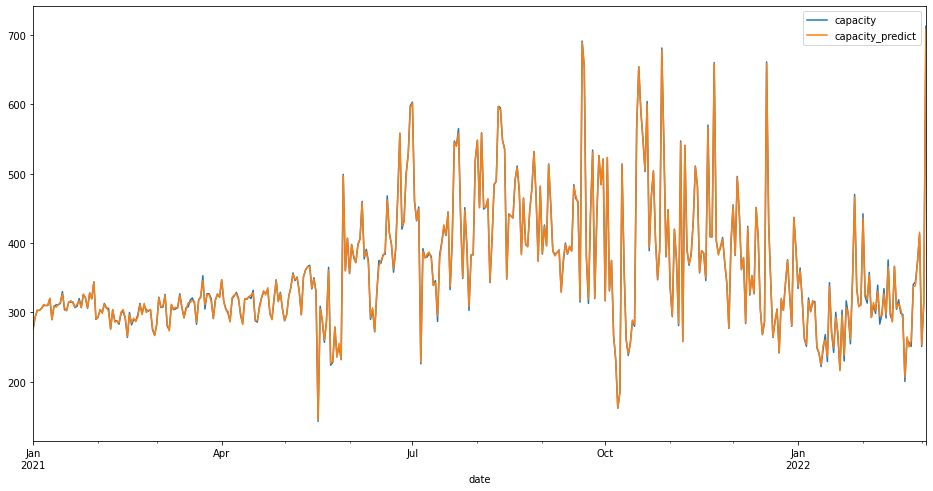

In [35]:
result_df.plot(label='first_data', figsize=(16,8))

In [36]:
result_df = result_df.reset_index(level=0)
result_df.head()

,date,capacity,capacity_predict
0,2021-01-01,276.0,276.002197
1,2021-01-02,293.0,293.884460
2,2021-01-03,303.0,303.165710
3,2021-01-04,303.0,302.848816
4,2021-01-05,306.0,305.601990


### test

In [39]:
X_test_list =[]
Y_test_list =[]

for i in range(len(test['date'])):
  X = []
  Y = []
  X.extend([test.iloc[i]['year'],test.iloc[i]['month'],test.iloc[i]['day'],test.iloc[i]['day_of_week']])
  Y.append(test.iloc[i]['capacity'])
  X_test_list.append(X)
  Y_test_list.append(Y)
X_test_list = np.array(X_test_list)
Y_test_list = np.array(Y_test_list)

In [40]:
y_test_pred = xgb_model.predict(X_test_list)
print(len(y_test_pred))
mse=mean_squared_error(Y_test_list, y_test_pred)
print('test',np.sqrt(mse))

15
test 144.9634980313868


In [41]:
test_result_df = test[['date','capacity']]
test_result_df['capacity_predict'] = y_test_pred
test_result_df.head()

C:\Users\User\AppData\Local\Temp/ipykernel_21604/1548298200.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_result_df['capacity_predict'] = y_test_pred


,date,capacity,capacity_predict
62,2022-03-04,326.1,586.676758
63,2022-03-05,433.8,444.321930
64,2022-03-06,463.2,439.964600
65,2022-03-07,252.7,437.690002
66,2022-03-08,329.0,459.642273


<AxesSubplot:xlabel='date'>

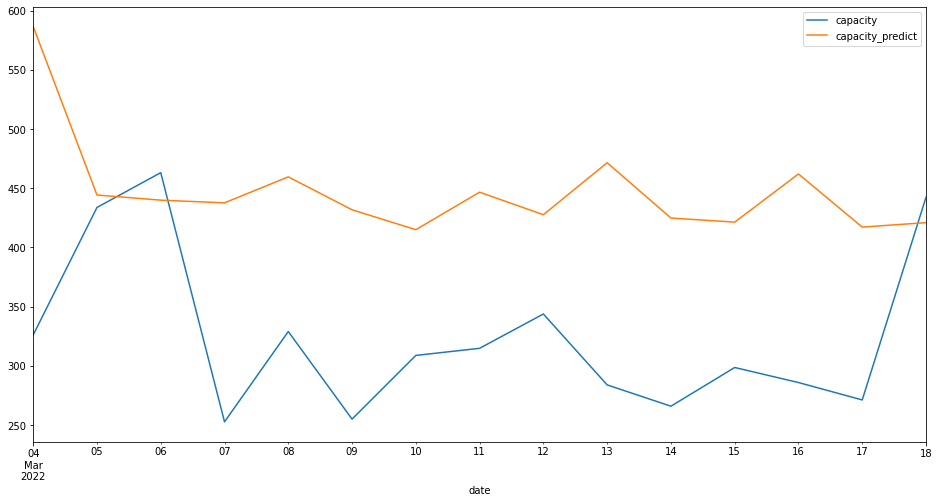

In [42]:
test_result_df.set_index('date',inplace=True)
test_result_df.plot(label='test_data', figsize=(16,8))

## ARIMA 整合移動平均自我迴歸模型
https://adaptable-haze-butterfly-551.medium.com/arima%E6%99%82%E9%96%93%E5%BA%8F%E5%88%97%E6%A8%A1%E5%9E%8Bpython%E6%87%89%E7%94%A8-%E9%8A%85%E5%83%B9%E6%A0%BC%E9%A0%90%E6%B8%AC-%E4%B8%80-4f91693e3ec6  
時間序列演算法 參考資料：https://blog.csdn.net/weixin_43861350/article/details/110008352#ARIMA__25